TIFF
(251, 165)
RGB


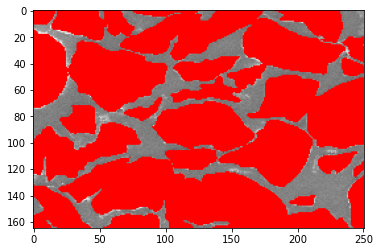

In [44]:
import os
import matplotlib
import xlrd
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from PIL import Image
# Open the image form working directory
#NOTE: Image MUST be RGB with active material in red (RGB = 255,0,0) and pores in any other color
#The image processing can be done in ImageJ by adjusting Color Threshold
fileName = 'MLA081_manualTop.tif'
image = Image.open(fileName)
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)
# show the image
plt.imshow(image)

In [45]:
#Gather pixel data from the image and store as an array
from numpy import asarray
data = asarray(image)
print(type(data))
print(data.shape)
print(len(data))

#Change all non-red pixels to black

<class 'numpy.ndarray'>
(165, 251, 3)
165


In [46]:
#Defining new functions for calculating pore size
#The functions calculate closest distance between 2 pixels colored red based on a nearest-neighbor model
#This is done by splitting the image into 4 quadrants based on the current pixel sampled and calculating 
#the shortest distance in each quadrant
#Arguments are the current coordinate of the sampled pixel (X,Y) and the matrix of RGB values

#Sampling Quadrant 1 for the specified pixel
def distCalcQ1(X,Y,matr):

    if matr[X][Y+1] == 255 and matr[X-1][Y] == 255 and matr[X-1][Y+1] == 255:
        dist = 0
        return dist
    else:
        dist = 100000000000.0
        #length of the rows (i.e. number of columns)
        rowDim = len(matr[0])
        #length of the columns (i.e. number of rows)
        colDim = len(matr)
        for b in range(Y,rowDim):
            for a in range(1,X+1):
                if matr[a][b] == 255:
                    temp = ((X-a)**2+((b-Y)**2))**0.5
                    if temp < dist and temp != 0:
                        dist = temp
                    else:
                        continue
        if dist == 100000000000.0:
            dist = 0    
    return dist
                    

#Sampling Quadrant 2 for the specified pixel            
def distCalcQ2(X,Y,matr):
    if matr[X][Y-1] == 255 and matr[X-1][Y] == 255 and matr[X-1][Y-1] == 255:
        dist = 0
        return dist
    else:
        dist = 100000000000.0
        #length of the rows (i.e. number of columns)
        rowDim = len(matr[0])
        #length of the columns (i.e. number of rows)
        colDim = len(matr)
        for b in range(0,Y+1):
            for a in range(0,X+1):
                if matr[a][b] == 255:
                    temp = ((X-a)**2+((b-Y)**2))**0.5
                    if temp < dist and temp !=0:
                        dist = temp
                    else:
                        continue
        if dist == 100000000000.0:
            dist = 0    
    return dist

#Sampling Quadrant 3 for the specified pixel            
def distCalcQ3(X,Y,matr):
    if matr[X][Y-1] == 255 and matr[X+1][Y] == 255 and matr[X+1][Y-1] == 255:
        dist = 0
        return dist
    else:
        dist = 100000000000.0
        #length of the rows (i.e. number of columns)
        rowDim = len(matr[0])
        #length of the columns (i.e. number of rows)
        colDim = len(matr)
        for b in range(0,Y+1):
            for a in range(X,colDim):
                if matr[a][b] == 255:
                    temp = ((X-a)**2+((b-Y)**2))**0.5
                    if temp < dist and temp !=0:
                        dist = temp
                    else:
                        continue
        if dist == 100000000000.0:
            dist = 0    
    return dist

#Sampling Quadrant 4 for the specified pixel            
def distCalcQ4(X,Y,matr):
    if matr[X+1][Y+1] == 255 and matr[X+1][Y] == 255 and matr[X][Y+1] == 255:
        dist = 0
        return dist
    elif matr[X][Y] != 255:
        dist = 0
        return dist
    else:
        dist = 100000000000.0
        #length of the rows (i.e. number of columns)
        rowDim = len(matr[0])
        #length of the columns (i.e. number of rows)
        colDim = len(matr)
        for b in range(Y,rowDim):
            for a in range(X,colDim):
                if matr[a][b] == 255:
                    temp = ((X-a)**2+((b-Y)**2))**0.5
                    if temp < dist and temp !=0:
                        dist = temp
                    else:
                        continue
        if dist == 100000000000.0:
            dist = 0    
    return dist
#Testing the 4 functions here
testMatrix = [[0,0,255,0],[0,0,0,0],[0,255,0,255],[0,0,0,0],[0,0,255,0],[0,0,0,0]]
print(distCalcQ1(4,2,testMatrix))
print(distCalcQ2(4,2,testMatrix))
print(distCalcQ3(4,2,testMatrix))
print(distCalcQ4(4,2,testMatrix))

2.23606797749979
2.23606797749979
0
0


In [55]:
#Initializing a matrix for entering pore sizes (in pixels) calculated at a certain pixel
poreSizes_pixel = np.zeros((len(data),len(data[0])),dtype=float)
#Number of Rows
print('Number of Rows:',len(poreSizes_pixel))
#Number of Columns
print('Number of Columns:',len(poreSizes_pixel[0]))

#Only retrieving the R values in RGB for the pixels in the image. Assumption: all active particles have R= 255 and all
#pore regions have R not equal to 255
data1 = np.zeros((len(data),len(data[0])),dtype=float)
for a in range(0,len(data)-1):
    for b in range(0,len(data[0])-1):
        data1[a][b] = data[a][b][0]
        

#Note: Since we're not accounting for periodic boundary conditions, the "outer edge" of pixels will not be calculated
#This is the main script
poreList_pixel = []
for a in range(1,len(data1)-1):
    for b in range(1,len(data1[0])-1):
        if data1[a][b] == 255:
            dist1 = distCalcQ1(a,b,data1)
            dist2 = distCalcQ2(a,b,data1)
            dist3 = distCalcQ3(a,b,data1)
            dist4 = distCalcQ4(a,b,data1)
            temp2 = [dist1,dist2,dist3,dist4]
            if dist1 != 0 or dist2 != 0 or dist3 != 0 or dist4 != 0:
                temp3 = []
                for m in range(len(temp2)):
                    #Change this if statement as needed. 
                    #(i.e. if a "pore size" of 2 pixels is an artifact of bad color contrast/image processing 
                    #[2 pixels not being a pore], then change to > 2)
                    if temp2[m] > 1:
                        temp3.append(temp2[m])
                        
                #If temp3 is empty (i.e. condition of pore size being big enough not satisfied)
                #Then set the pore size to zero (We will remove all 0's later)
                if not temp3:
                    poreSizes_pixel[a][b] = 0;
                    #poreList_pixel.append(0)
                else:
                    #Deleting any 0's before finding the minimum pore size
                    for n in range(len(temp3)):
                        np.delete(temp3[n],0)
                    poreSizes_pixel[a][b] = min(temp3) 
                    #poreList_pixel.append(min(temp3))
            else:
                poreSizes_pixel[a][b] = 0
        else:
            poreSizes_pixel[a][b] = 0
            
            
poreSizes_pixel_edited = []
#Removing all 0's from the pore size list
for a in range(len(poreSizes_pixel)):
    for b in range(len(poreSizes_pixel[0])):
        if poreSizes_pixel[a][b] != 0:
            poreSizes_pixel_edited.append(poreSizes_pixel[a][b])

            
#Finding the average pore diameter
PoreDiamSum_pixel = 0.0
PoreDiamAvg_pixel = 0.0
PoreDiamSum = 0.0
for a in range(0,len(poreSizes_pixel_edited)):
        PoreDiamSum += poreSizes_pixel_edited[a]
        
#Converting from pixels to microns (or other length scale)
PixelNum = len(poreSizes_pixel_edited)
PoreDiamAvg_pixel = PoreDiamSum/PixelNum
PoreRadAvg_pixel = PoreDiamAvg_pixel/2
print('Average Pore Radius (Pixels):', PoreRadAvg_pixel)
#Enter/Change Pixel Aspect Ratio (e.g. pixels/micron)
#To obtain this value from ImageJ/Fiji: Open the image and draw a line over the full width of the scale bar
#(This assumes that the images are SEM micrographs of cross-sections with scale bars)
#Click Analyze, then click Set Scale. Type in the known distance of the scale bar and the unit of length. 
#The pixel to distance ratio will show on the bottom

PixRat = 3.19
PoreRadAvg_micron = PoreRadAvg_pixel/PixRat
print('Average Pore Radius (Microns):', PoreRadAvg_micron)

Number of Rows: 165
Number of Columns: 251
Average Pore Radius (Pixels): 3.081800125305199
Average Pore Radius (Microns): 0.966081543982821
